# **Predicting Fatal Victims of the Titanic Sinking**

Inspired by the notebook of Ravi Ramakrishnan on kaggle. Available [here](https://www.kaggle.com/code/ravi20076/titanic-eda-model-custompipelines)

In [1]:
import pandas as pd
import seaborn as sns
from termcolor import colored
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

/home/gabriel/Documents/ScikitDemo/demo/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from sklearn.preprocessing import (
    StandardScaler, 
    MinMaxScaler, 
    RobustScaler, 
    Normalizer, 
    QuantileTransformer, 
    PowerTransformer,
    FunctionTransformer,
    LabelEncoder, 
    OneHotEncoder, 
    OrdinalEncoder,
)

from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.impute import MissingIndicator

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn_pandas import DataFrameMapper, gen_features

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import BaseEstimator, TransformerMixin;


## Data Understanding

In [3]:
raw_train = pd.read_csv('./data/train.csv')
raw_test = pd.read_csv('./data/test.csv')

X, y = raw_train.drop('Survived', axis=1), raw_train['Survived']


### First look at data

It's possible to perceive that Name, Sex, Ticket, Cabin, and Embarked are all categorical attributes, and they need to be processed

In [662]:
print(colored(f'\nTrain Data dimensions : {raw_train.shape}\n', color='green', attrs=['bold']))

for t in raw_train.dtypes.unique():
    s = ', '.join(raw_train.select_dtypes(t).columns.values)
    print(colored(f'{t} : {s}', color='blue', attrs=['bold']))


Train Data dimensions : (891, 12)

int64 : PassengerId, Survived, Pclass, SibSp, Parch
object : Name, Sex, Ticket, Cabin, Embarked
float64 : Age, Fare



Missing Values (%) per Dataset


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
Train Data,0.0,0.0,0.0,0.0,19.87,0.0,0.0,0.0,0.00,77.10,0.22
Test Data,0.0,0.0,0.0,0.0,20.57,0.0,0.0,0.0,0.24,78.23,0.00


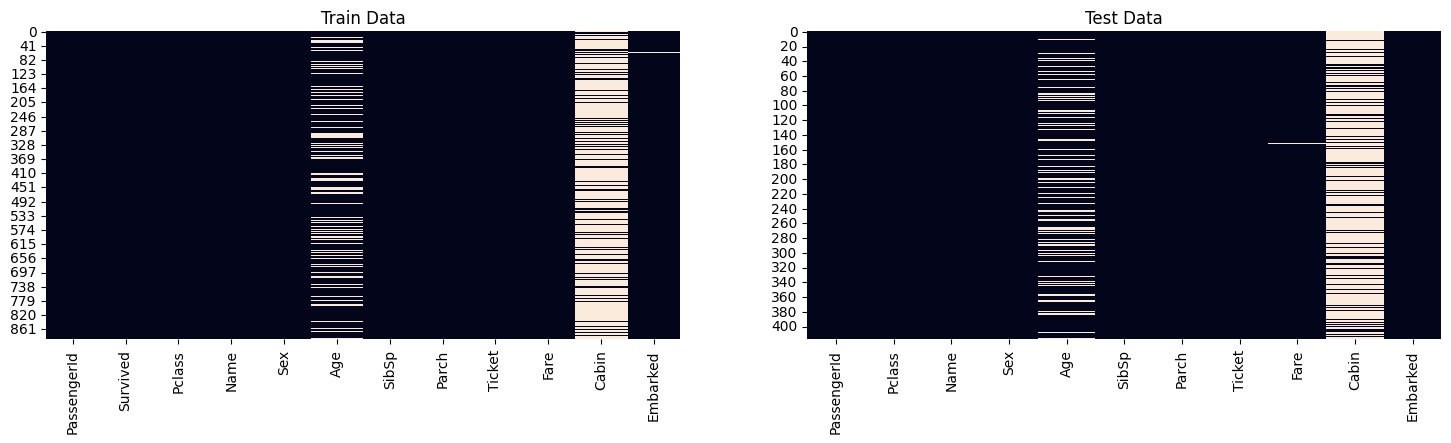

In [661]:
_ = pd.DataFrame(
    data=[
        raw_train.drop('Survived', axis=1).isna().mean().round(4) * 100,
        raw_test.isna().mean().round(4) * 100
    ],
    columns=raw_test.columns,
    index=['Train Data', 'Test Data']
)

print(colored('\nMissing Values (%) per Dataset', color='green', attrs=['bold']))
display(_)

# --------------- Plot Missing Values Heatmap ---------------
fig, ax = plt.subplots(1, 2, figsize=(18, 4))

sns.heatmap(raw_train.isna(), cbar=False, ax=ax[0])
sns.heatmap(raw_test.isna(), cbar=False, ax=ax[1])
ax[0].set_title('Train Data')
ax[1].set_title('Test Data')
plt.show()

###  Visualizing training dataset description

Fare and Age have a bigger spread on their values 

In [8]:
print(colored(f'Training dataset description\n', color='green', attrs=['bold']))
display(raw_train.describe())

Training dataset description



,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [90]:
def get_feature_states(df, feature):
    skew = df.skew()[feature].round(1)
    kurtosis = df.kurtosis()[feature].round(1)
    mode = df.mode()[feature].values[0]
    mean = df.mean()[feature].round(2)
    return (skew, kurtosis, mode, mean)

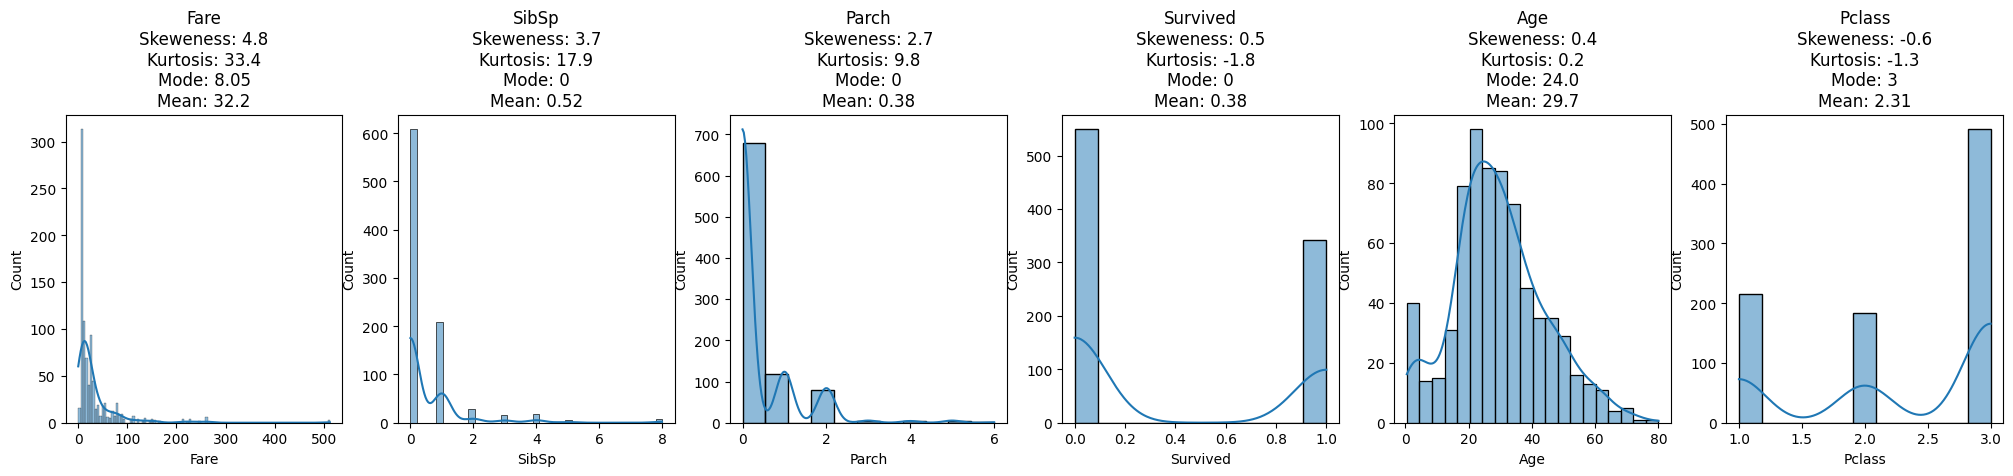

In [132]:
# Get the numerical columns ordered by right skeweness and save their indexes in 'features_to_print'
_ = raw_train.select_dtypes('number').drop('PassengerId', axis=1)
features_to_print = _.skew().sort_values(ascending=False).index

fig, ax = plt.subplots(1, len(features_to_print), figsize=(25, 4))

for i, feature in enumerate(features_to_print):
    ax_t = ax[i]
    sns.histplot(data=_[feature], kde=True, ax=ax_t)

    skew, kurtosis, mode, mean = get_feature_states(_, feature)
    title = f'{feature}\nSkeweness: {skew}\nKurtosis: {kurtosis}\nMode: {mode}\nMean: {mean}'
    ax_t.set_title(title)

In [10]:
print(colored(f'\nUnique values by categorical feature\n', color='blue', attrs=['bold']))
display(raw_train.select_dtypes('object').nunique().sort_values(ascending=False))


Unique values by categorical feature



Name        891
Ticket      681
Cabin       147
Embarked      3
Sex           2
dtype: int64

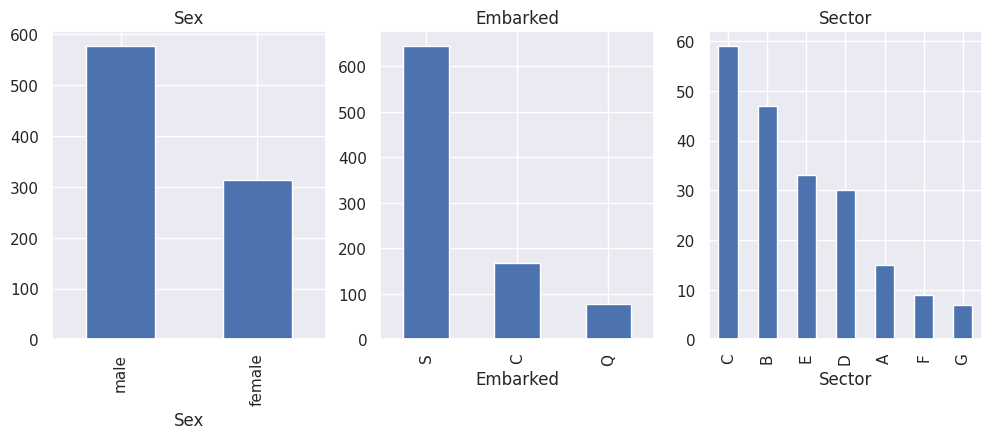

In [158]:
_ = raw_train.assign(Sector=raw_train['Cabin'].str.extract(r'([A-Za-z])(\d+)', expand=False)[0])
cat_df = _.select_dtypes('object').drop(['Name', 'Cabin', 'Ticket'], axis=1)

fig, ax = plt.subplots(1, len(cat_df.columns), figsize=(12, 4))

for i, column in enumerate(cat_df.columns):
    ax_t = ax[i]
    cat_df[column].value_counts().plot(kind='bar', ax=ax_t)
    ax_t.set_title(column)

In [19]:
# Drop undesired columns

def Prum_features(X: pd.DataFrame, y=None):
    X_t = X.copy()
    # X_t['Ticket_Frequency'] = X_t.groupby('Ticket')['Ticket'].transform('count')
    X_t['Is_Child'] = (X_t['Name'].str.contains('Master')).astype(int)
    X_t = X_t.drop(['PassengerId', 'Name', 'Ticket'], axis=1)
    return X_t

In [20]:
'''
Is_Married = True if its married
Family_Size = SibSp + Parch
Is_Elderly = Above 60 years old
Ticket_frequency = How many times this ticket appears
'''

class FeatureConstructor(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X_t = X.copy()
        # X_t['Family_Size'] = X_t['SibSp'] + X_t['Parch']
        X_t['Is_Elderly'] = (X_t['Age'] > 60).astype(int)
        return X_t

In [21]:
'''
Age Column -> Fill NaN values by taking the mean age of (Pclass, Sex)

Cabin Column -> 
    - Create a Sector Column
    - Fill NaN values by taking the most probable sector based on the Pclass and Fare
    - Drop Cabin 
'''

class SpecializedImputer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.sectors = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T']
    
    def fit(self, X, y=None):

        # Dictionary with the mean fare per Pclass
        # Example   1: 84.1546
        self.map_fare = X.groupby('Pclass').agg({'Fare': 'mean'}).to_dict()['Fare']

        # Dictionary with the mean age for each (Pclass, Sex) group. 
        # Example   (1, female): 34.0
        self.map_age = X.groupby(['Pclass', 'Sex']).agg({'Age': 'mean'}).to_dict()['Age']
        
        # Dictionary with the mean age for each (Sector, Pclass) group
        # Example   (B, 1, male): 178.0
        self.map_cabin = X \
            .assign(Sector=X['Cabin'] \
            .str.extract(r'([A-Za-z])(\d+)', expand=False)[0]) \
            .groupby(['Sector', 'Pclass']) \
            .agg({'Fare': 'mean'}) \
            .to_dict()['Fare']
        
        return self

    def transform(self, X, y=None):
        X_t = X.copy()
        
        # Fare Column
        X_t['Fare'] = X_t.apply(
            axis = 1,
            func = lambda x: self.map_fare[x['Pclass']] if pd.isna(x['Fare']) else x['Fare'],
        )

        # Age Column
        X_t['Age'] = X_t.apply(
            axis = 1,
            func = lambda x: self.map_age[(x['Pclass'], x['Sex'])] if pd.isna(x['Age']) else x['Age'],
        )

        # Sector (new Cabin) Column
        X_t['Sector'] = X_t.apply(
            axis = 1,
            func = lambda x: self.get_probable_sector(x['Pclass'], x['Fare']) if pd.isna(x['Cabin']) else x['Cabin'][0],
        )
        return X_t.drop('Cabin', axis=1, errors='ignore')

    def get_probable_sector(self, pclass, fare):
        KEY_NOT_FOUND = 999_999_999 # Garantees that non existent keys dont become the minimum
        fare_diffs = {
            sector: abs(fare - self.map_cabin.get((sector, pclass), KEY_NOT_FOUND)) \
            for sector \
            in self.sectors
        }
        return min(fare_diffs, key=fare_diffs.get)

In [28]:
Categorical_encoder = DataFrameMapper([
    (['Embarked'], [SimpleImputer(strategy='most_frequent'), OneHotEncoder()]),
    (['Sector'],   OrdinalEncoder(categories=[['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T']])),
    ('Sex', LabelEncoder()),
], df_out=True, default=None)

cols = ['Age', 'Fare', 'SibSp', 'Parch']
Scaling = DataFrameMapper(
    gen_features(
        columns=[col.split(' ') for col in cols],
        classes=[RobustScaler],
    ),
    df_out=True, default=None)

Data_pipe = Pipeline(verbose=True,
    steps=[
        ('prumming_unwanted', FunctionTransformer(func=Prum_features)),
        ('enriching_features', FeatureConstructor()),
        ('specialized_imputer', SpecializedImputer()),
        ('categorical_encoder', Categorical_encoder),
        ('scaler', Scaling),
    ]
)

In [29]:
Data_pipe.fit(X.copy(), y)

X_train_processed = Data_pipe.transform(X)
X_test_processed = Data_pipe.transform(raw_test)


grid = GridSearchCV(
    estimator = RandomForestClassifier(criterion='gini', random_state=34), 
    param_grid = {
        'n_estimators': range(600, 1000, 100),
        'max_depth': range(5,8,1),
        'min_samples_split': [4, 6],
        'min_samples_leaf': [5, 6],
    },
    n_jobs=2,
    cv=5,
)

[Pipeline] . (step 1 of 5) Processing prumming_unwanted, total=   0.0s
[Pipeline]  (step 2 of 5) Processing enriching_features, total=   0.0s
[Pipeline]  (step 3 of 5) Processing specialized_imputer, total=   0.1s
[Pipeline]  (step 4 of 5) Processing categorical_encoder, total=   0.0s
[Pipeline] ............ (step 5 of 5) Processing scaler, total=   0.0s


In [30]:
grid.fit(X_train_processed, y.ravel())
y_preds = grid.predict(X_test_processed)

# Save predictions
pd.DataFrame({
    'PassengerId': raw_test['PassengerId'],
    'Survived': y_preds.astype(int)
}).to_csv('predictions.csv', index=False)